In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Function for converting series data to a supervised data of format, t-1, t, t+1
## Basically feeding in the (t-1)th data to predict the t data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
 
# load dataset
dataset = read_csv('/Users/manali/Desktop/ASE/valet-tool/parse_tactics/normalized_tva_server_3_tactic_1_train.csv')
dataset= dataset.drop(columns=["timestamp","ping_timestamp","ping_success"])
values = dataset.values
print(dataset.head(5))
## Load Validation
validation = read_csv('/Users/manali/Desktop/ASE/valet-tool/parse_tactics/normalized_tva_server_3_tactic_1_test.csv')
validation= validation.drop(columns=["timestamp","ping_timestamp","ping_success"])
values_validation = validation.values


   time_since_last_recording   latency      cost  reliability  \
0                   0.000000  0.044391  0.078125            1   
1                   0.019803  0.042769  0.076172            1   
2                   0.018599  0.046944  0.078125            1   
3                   0.000335  0.048774  0.050781            1   
4                   0.006088  0.051200  0.076172            1   

   time_since_last_ping  ping_time  
0              0.000000   0.000000  
1              0.000000   0.000000  
2              0.006728   0.038745  
3              0.007068   0.038745  
4              0.000680   0.038481  


In [4]:
## Calling the function to do the preprocessing the data and removing unwanted columns


# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed_validation = series_to_supervised(values_validation, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,10,11]], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[[6,10,11]], axis=1, inplace=True)
print(reframed.head(1))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var2(t)  \
1        0.0   0.044391   0.078125        1.0        0.0        0.0  0.042769   

    var3(t)  var4(t)  
1  0.076172      1.0  


In [5]:
## Splitting the data into training and validation sets


train = reframed.values
test = reframed_validation.values
# split into input and outputs
train_X, train_y = train[:, :-3], train[:,-3:]
test_X, test_y = test[:, :-3], test[:,-3:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12158, 1, 6) (12158, 3) (2604, 1, 6) (2604, 3)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1000)              4028000   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3003      
Total params: 4,031,003
Trainable params: 4,031,003
Non-trainable params: 0
_________________________________________________________________
None
Train on 12158 samples, validate on 2604 samples
Epoch 1/20
12158/12158 [==============================] - 8s 653us/step - loss: 0.0237 - val_loss: 0.0010
Epoch 2/20
12158/12158 [==============================] - 7s 595us/step - loss: 0.0015 - val_loss: 7.8762e-04
Epoch 3/20
12158/12158 [==============================] - 7s 571us/step - loss: 0.0014 - val_loss: 7.5476e-04
Epoch 4/20
12158/12158 [==============================] - 7s 610us/step - loss: 0.0013 - val_loss: 7.4077e-04
Epoch 5/20
12158

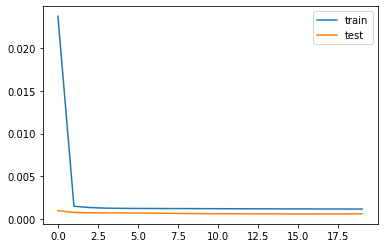

In [6]:
# design LSTM network  has 1000 hidden layers , used adam optimizer and mse loss function
model = Sequential()
model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))

print(model.summary())

model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
### Doing the same process for testing dataset

#test_dataset = read_csv('normalized_tva_server_2_tactic_1_validation.csv')
test_dataset = read_csv('/Users/manali/Desktop/ASE/valet-tool/parse_tactics/normalized_tva_server_3_tactic_1_validation.csv')
test_dataset= test_dataset.drop(columns=["timestamp","ping_timestamp","ping_success"])
print(test_dataset.head())
test_values = test_dataset.values
reframed_test = series_to_supervised(test_values, 1, 1)
reframed_test.drop(reframed_test.columns[[6,10,11]], axis=1, inplace=True)
testset = reframed_test.values
testset_X, testset_y = testset[:, :-3], testset[:,-3:]
testdataReshaped = testset_X.reshape((testset_X.shape[0], 1, testset_X.shape[1]))
print(testset_X.shape, testset_X.shape)

   time_since_last_recording   latency      cost  reliability  \
0                   0.005620  0.060326  0.046875            1   
1                   0.012578  0.196410  0.027344            1   
2                   0.002275  0.157676  0.031250            1   
3                   0.000937  0.124168  0.039062            1   
4                   0.003078  0.127279  0.023438            1   

   time_since_last_ping  ping_time  
0              0.010126   0.039746  
1              0.007816   0.039680  
2              0.001631   0.039549  
3              0.002583   0.039549  
4              0.000612   0.039764  
(2606, 6) (2606, 6)


In [8]:
## Feeding the test dataset for predictions
import pandas as pd

yhat = model.predict(testdataReshaped)

print(yhat)
dataset = pd.DataFrame({'predicted_Latency': yhat[:, 0], 'predicted_Cost': yhat[:, 1],
                       'predicted_Reliability': yhat[:, 2]})
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] >0.5] = 1
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] <0.5] = 0

[[0.06685364 0.0701643  0.9910082 ]
 [0.09275403 0.06529443 0.9951839 ]
 [0.08367596 0.06684301 0.9932254 ]
 ...
 [0.07651893 0.06826323 0.991641  ]
 [0.10803541 0.06443015 1.0036418 ]
 [0.09622905 0.06691898 1.0025218 ]]


In [9]:
frames = [test_dataset, dataset]
result = pd.concat(frames,axis =1)

In [10]:
import numpy as np
result.head(10)
result.to_csv('/Users/manali/Desktop/PingPredictions/predictions_LSTM_server3_tactic1_Normalized.csv', sep=',', index=0)

In [11]:
print(testset_y)

[[0.19641042 0.02734375 1.        ]
 [0.15767574 0.03125    1.        ]
 [0.1241682  0.0390625  1.        ]
 ...
 [0.28741926 0.03515625 1.        ]
 [0.2223205  0.04882812 1.        ]
 [0.05357759 0.06835938 1.        ]]


In [12]:
## Finding the root mean squared error of the model
import numpy as np

rmse = np.sqrt(mean_squared_error(yhat, testset_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.040
